In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import control as ct
import lmfit
from pytz import timezone
import vaex
import pvlib

import sys
sys.path.append('../../../')

from utils.plot import config_matplotlib, figsize, fig_save_and_show  # noqa: E402

config_matplotlib()
latex_img_path = '/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs/'

# Data

In [2]:
tzinfo = timezone("America/Sao_Paulo")

events = [
    {
        "name": "01.Curta",
        "start": pd.Timestamp(
            year=2020, month=1, day=29, hour=13, minute=51, second=59, tzinfo=tzinfo
        ),
        "end": pd.Timestamp(
            year=2020, month=1, day=29, hour=14, minute=20, second=25, tzinfo=tzinfo
        ),
    },
    {
        "name": "02.Longa",
        "start": pd.Timestamp(
            year=2020, month=1, day=30, hour=11, minute=16, second=45, tzinfo=tzinfo
        ),
        "end": pd.Timestamp(
            year=2020, month=1, day=30, hour=14, minute=55, second=30, tzinfo=tzinfo
        ),
    },
    {
        "name": "03.Revezamento",
        "start": pd.Timestamp(
            year=2020, month=1, day=31, hour=11, minute=23, second=23, tzinfo=tzinfo
        ),
        "end": pd.Timestamp(
            year=2020, month=1, day=31, hour=12, minute=27, second=23, tzinfo=tzinfo
        ),
    },
    {
        "name": "04.Curta",
        "start": pd.Timestamp(
            year=2020, month=2, day=1, hour=10, minute=15, second=15, tzinfo=tzinfo
        ),
        "end": pd.Timestamp(
            year=2020, month=2, day=1, hour=11, minute=37, second=28, tzinfo=tzinfo
        ),
    },
    {
        "name": "05.Curta",
        "start": pd.Timestamp(
            year=2020, month=2, day=1, hour=13, minute=15, second=9, tzinfo=tzinfo
        ),
        "end": pd.Timestamp(
            year=2020, month=2, day=1, hour=13, minute=32, second=55, tzinfo=tzinfo
        ),
    },
    {
        "name": "07.Sprint",
        "start": pd.Timestamp(
            year=2020, month=2, day=2, hour=11, minute=58, second=27, tzinfo=tzinfo
        ),
        "end": pd.Timestamp(
            year=2020, month=2, day=2, hour=11, minute=59, second=9, tzinfo=tzinfo
        ),
    },
]

events = pd.DataFrame(events).set_index('name')
events

,start,end
name,,
01.Curta,2020-01-29 13:51:59-03:00,2020-01-29 14:20:25-03:00
02.Longa,2020-01-30 11:16:45-03:00,2020-01-30 14:55:30-03:00
03.Revezamento,2020-01-31 11:23:23-03:00,2020-01-31 12:27:23-03:00
04.Curta,2020-02-01 10:15:15-03:00,2020-02-01 11:37:28-03:00
05.Curta,2020-02-01 13:15:09-03:00,2020-02-01 13:32:55-03:00
07.Sprint,2020-02-02 11:58:27-03:00,2020-02-02 11:59:09-03:00


'original columns:'

Index(['Battery Pack Voltage', 'Pilot Duty Cycle', 'Pilot Motor On',
       'Pilot Boat On', 'ESC Duty Cycle', 'Motor Angular Speed',
       'MPPT 1 Input Voltage', 'MPPT 2 Input Voltage', 'MPPT 3 Input Voltage',
       'MPPT 4 Input Voltage', 'MPPT 1 Output Voltage',
       'MPPT 2 Output Voltage', 'MPPT 3 Output Voltage',
       'MPPT 4 Output Voltage', 'MPPT 1 Input Current', 'MPPT 2 Input Current',
       'MPPT 3 Input Current', 'MPPT 4 Input Current', 'MPPT 1 Duty Cycle',
       'MPPT 2 Duty Cycle', 'MPPT 3 Duty Cycle', 'MPPT 4 Duty Cycle',
       'MPPT 1 Input Power', 'MPPT 2 Input Power', 'MPPT 3 Input Power',
       'MPPT 4 Input Power', 'MPPTs Input Power', 'MPPT 1 Output Current',
       'MPPT 2 Output Current', 'MPPT 3 Output Current',
       'MPPT 4 Output Current', 'MPPTs Output Current', 'MPPT 1 Output Power',
       'MPPT 2 Output Power', 'MPPT 3 Output Power', 'MPPT 4 Output Power',
       'MPPTs Output Power', 'Battery Current', 'Battery Power',
       'ESC Input Curre

'renamed columns:'

{'Battery Pack Voltage': 'batt_v',
 'Battery Current': 'batt_i',
 'ESC Duty Cycle': 'esc_d',
 'Motor Angular Speed': 'motor_w',
 'ESC Input Power': 'esc_p_in',
 'ESC Input Current': 'esc_i_in',
 'MPPT 1 Input Current': 'mppt1_ii',
 'MPPT 2 Input Current': 'mppt2_ii',
 'MPPT 3 Input Current': 'mppt3_ii',
 'MPPT 4 Input Current': 'mppt4_ii',
 'MPPT 1 Input Voltage': 'mppt1_vi',
 'MPPT 2 Input Voltage': 'mppt2_vi',
 'MPPT 3 Input Voltage': 'mppt3_vi',
 'MPPT 4 Input Voltage': 'mppt4_vi',
 'MPPT 1 Duty Cycle': 'mppt1_d',
 'MPPT 2 Duty Cycle': 'mppt2_d',
 'MPPT 3 Duty Cycle': 'mppt3_d',
 'MPPT 4 Duty Cycle': 'mppt4_d',
 'MPPT 1 Output Current': 'mppt1_io',
 'MPPT 2 Output Current': 'mppt2_io',
 'MPPT 3 Output Current': 'mppt3_io',
 'MPPT 4 Output Current': 'mppt4_io',
 'Solar POA': 'solar_poa',
 'Wind Speed': 'wind_v',
 'Air Temperature': 'air_t'}

'selected columns:'

Index(['batt_v', 'batt_i', 'esc_d', 'motor_w', 'esc_p_in', 'esc_i_in', 'mppt1_ii',
       'mppt2_ii', 'mppt3_ii', 'mppt4_ii', 'mppt1_vi', 'mppt2_vi', 'mppt3_vi',
       'mppt4_vi', 'mppt1_d', 'mppt2_d', 'mppt3_d', 'mppt4_d', 'mppt1_io',
       'mppt2_io', 'mppt3_io', 'mppt4_io', 'solar_poa', 'wind_v', 'air_t'],
      dtype='object')

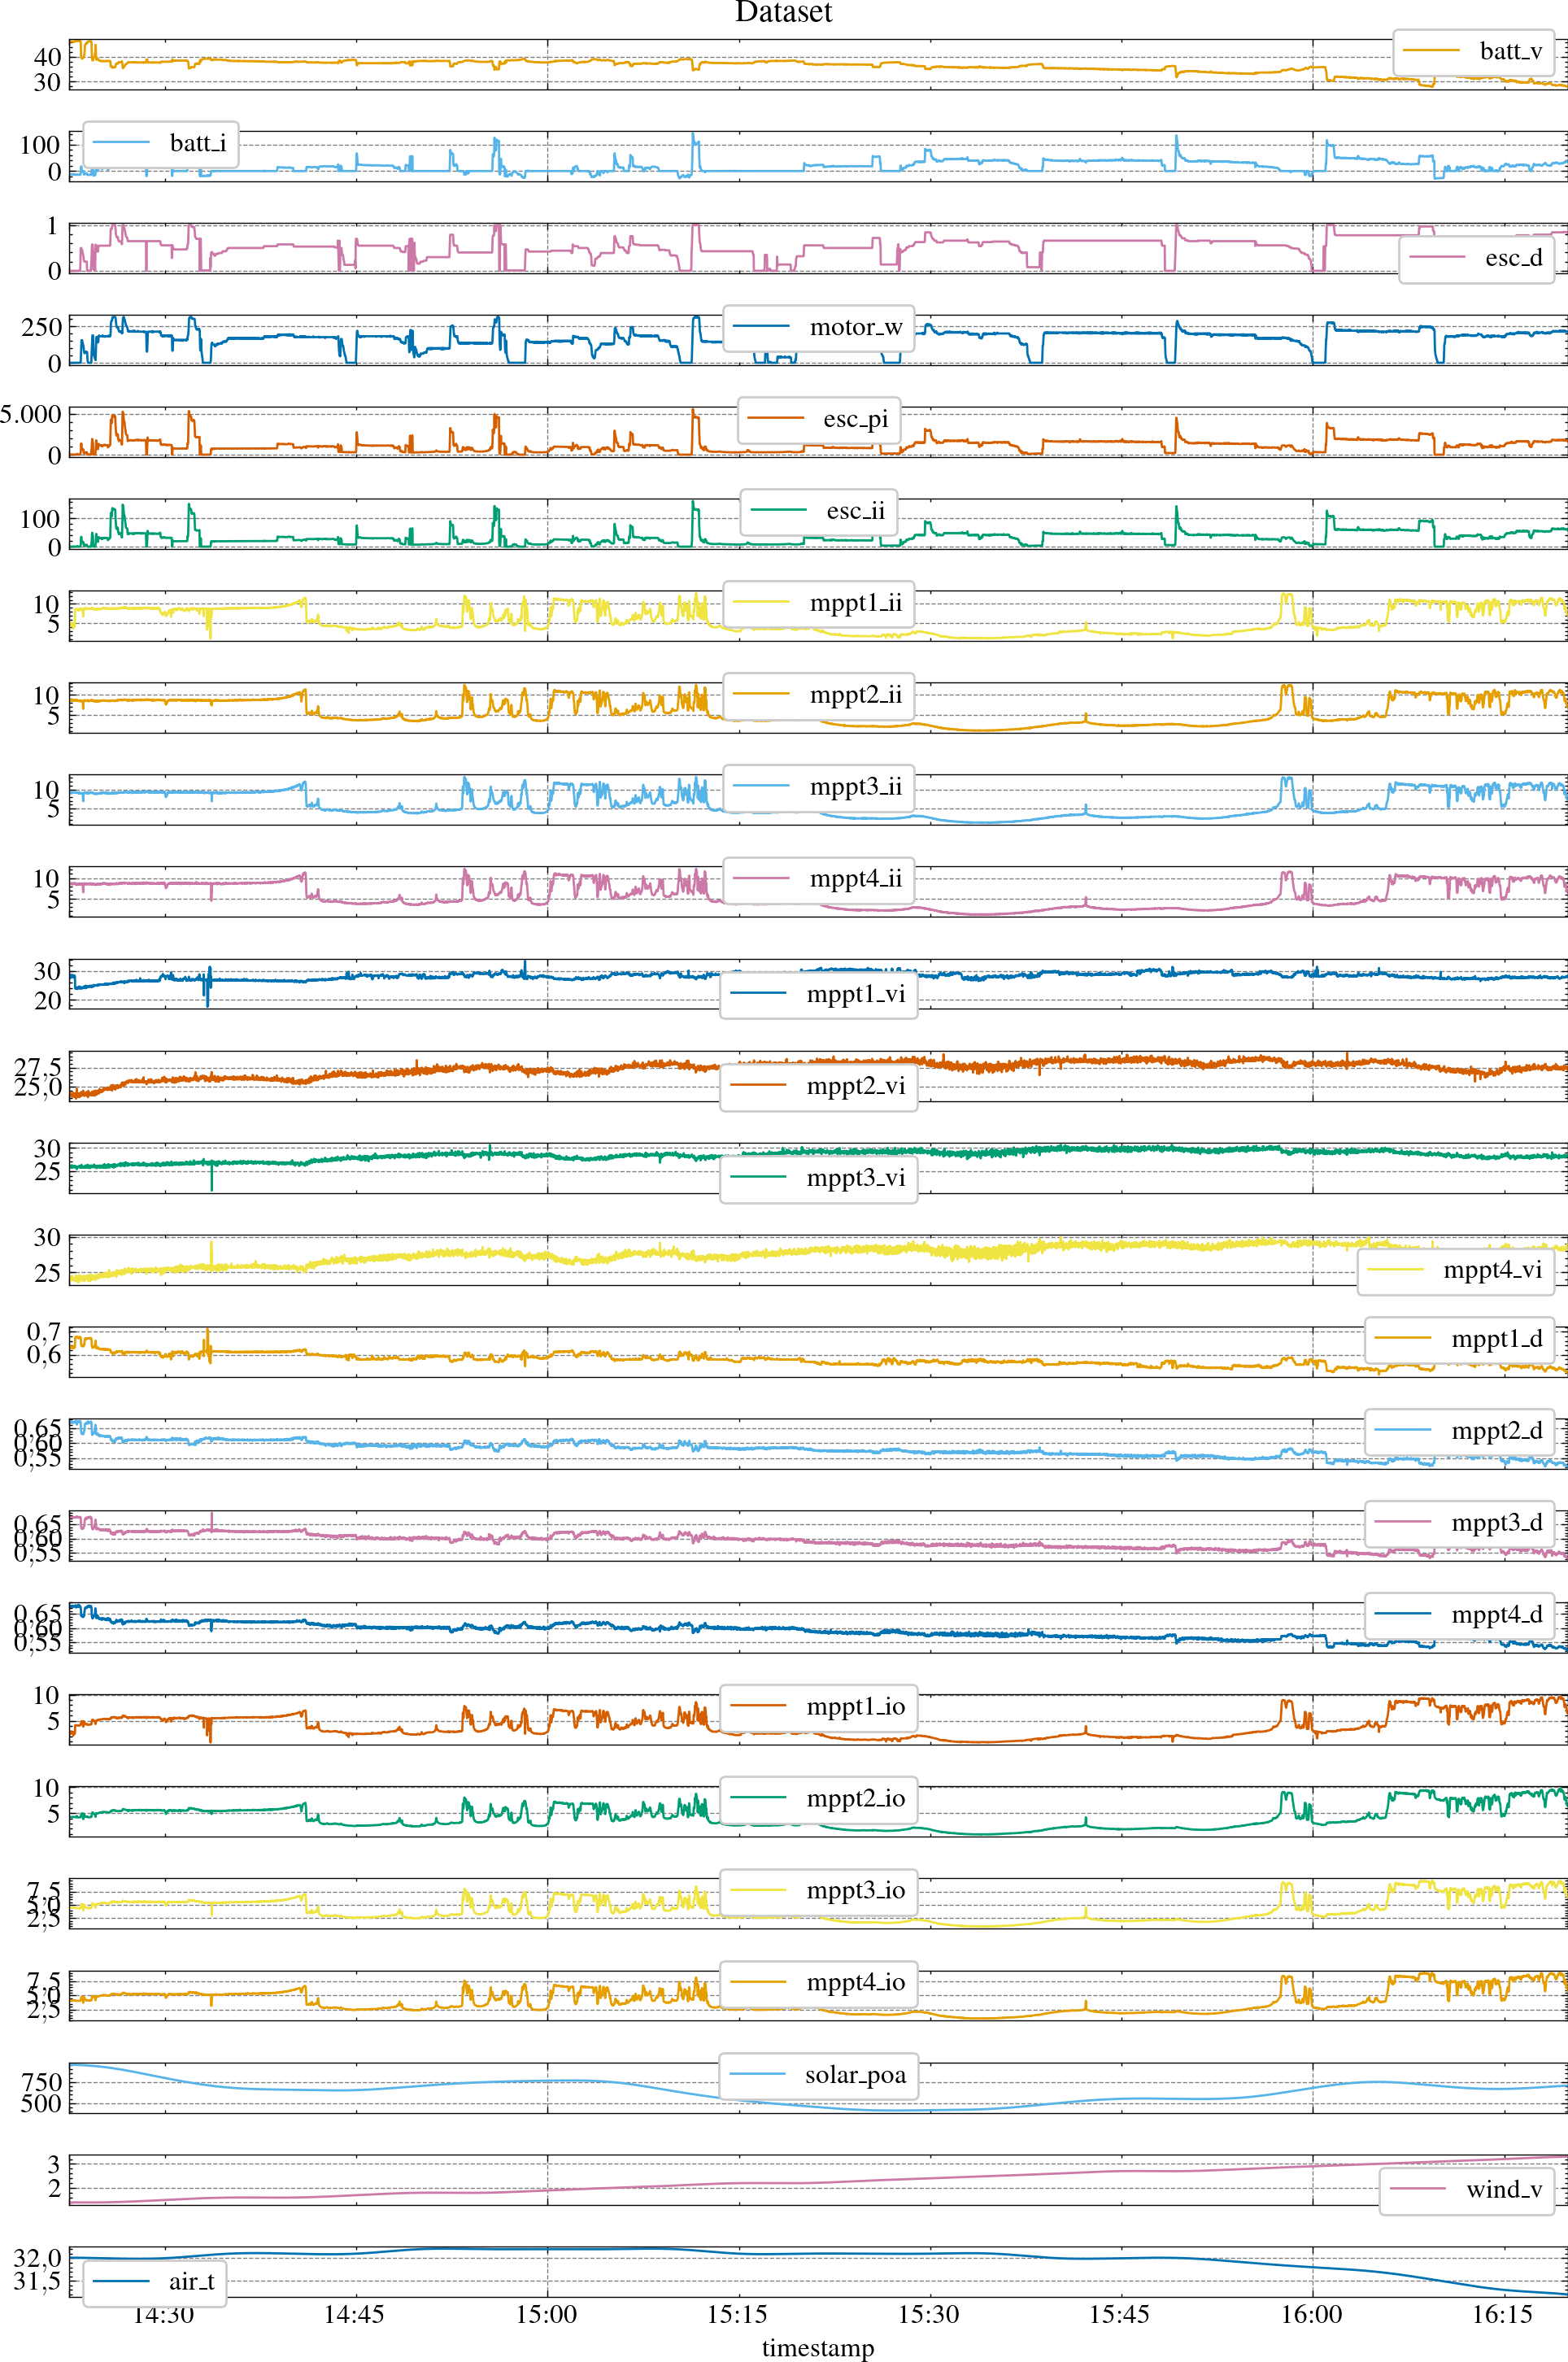

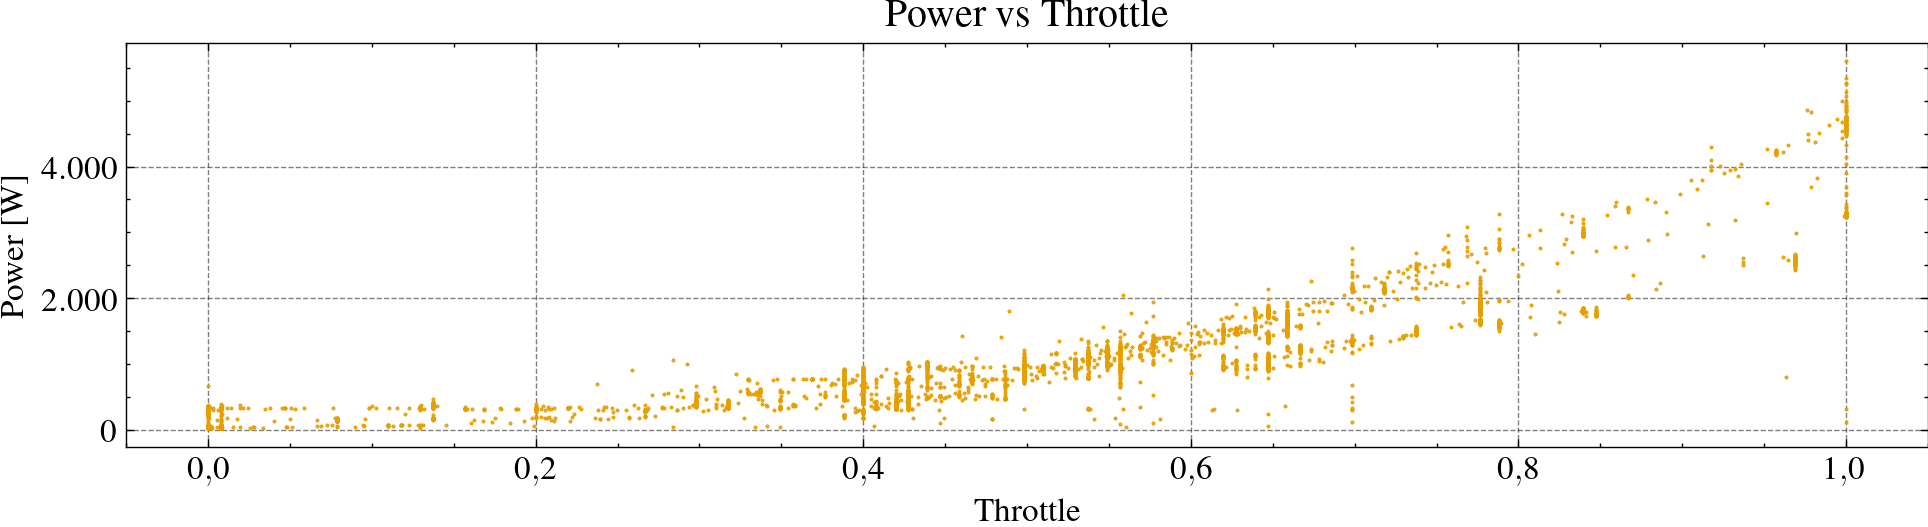

In [3]:
# From Revezamento
start = pd.Timestamp(
    year=2020, month=1, day=31, hour=11, minute=22, second=30, tzinfo=tzinfo
).tz_convert(None)
end = pd.Timestamp(
    year=2020, month=1, day=31, hour=13, minute=20, second=0, tzinfo=tzinfo
).tz_convert(None)

df = vaex.from_csv("../../../models/2020/boat_data_1s.csv").to_pandas_df()
# df = vaex.from_csv("../../../models/2020/boat_data_100ms.csv").to_pandas_df()
df["timestamp"] = pd.DatetimeIndex(df["timestamp"]).tz_convert(None)
df = df.set_index("timestamp")
display('original columns:', df.columns)

renamed_columns = {
    'Battery Pack Voltage': 'batt_v',
    'Battery Current': 'batt_i',
    'ESC Duty Cycle': 'esc_d',
    'Motor Angular Speed': 'motor_w',
    'ESC Input Power': 'esc_p_in',
    'ESC Input Current': 'esc_i_in',
    **{f'MPPT {i} Input Current': f'mppt{i}_i_in' for i in range(1,5)},
    **{f'MPPT {i} Input Voltage': f'mppt{i}_v_in' for i in range(1,5)},
    **{f'MPPT {i} Duty Cycle': f'mppt{i}_d' for i in range(1,5)},
    **{f'MPPT {i} Output Current': f'mppt{i}_i_out' for i in range(1,5)},
    'Solar POA': 'solar_poa',
    'Wind Speed': 'wind_v',
    'Air Temperature': 'air_t',
}
display('renamed columns:', renamed_columns)

df = df.loc[
    (df.index >= start) & (df.index <= end),
    renamed_columns.keys(),
].rename(columns=renamed_columns)

display('selected columns:', df.columns)

df = df.dropna()
df = df.resample('1s').mean().interpolate(method="time", limit_area='inside')
dfa = df.copy(deep=True)

df.plot(subplots=True, figsize=(10, 15))
plt.suptitle('Dataset')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,3))
plt.title('Power vs Throttle')
plt.xlabel('Throttle')
plt.ylabel('Power [W]')
plt.scatter(df['esc_d'], df['esc_p_in'], s=0.2)
plt.tight_layout()
plt.show()


# Parameters

In [4]:
from dataclasses import dataclass, asdict
from pprint import pformat, pprint
from copy import deepcopy

propulsion_params = {
    'motor_R_A': 0.04270952220548964,
    'motor_L_A': 0.816092845566883,
    'motor_B': 0.00213137765046113,
    'motor_I_r': 0.003371534938331495,
    'motor_I_r_load': 0.006634350941470065,
    'motor_K_Q': 0.10225268,
    'prop_K_T': 1, # disabled
    'prop_K_Q': 0.0011936690867098046,
    'prop_D': 0.21589999999999998,
    'rho_water': 1025,
    'rho_air': 1.1839,
    'trans_eta': 0.95,
    'esc_eta': 0.8,
    'trans_k': 0.5909090909090909,
    'hull_C_T': 1, # disabled
    'hull_S_air': 1, # disabled
    'hull_S_water': 1, # disabled
}

generation_params = {
    'pv_S': 1.650 * 0.992,
    'pv_eta': 0.1589,
    'mppt_eta': 0.9303414194668972,
    'mppts_n': 4,
}

battery_params = { # From: modelling_battery_nonlinear-sprint-dataset.ipynb
    'batt_eta': 1,
    'batt_Q': 38 * 3600,
    'batt_R_0': 0.07688995265604726,
    'batt_R_1': 0.007914593252093682,
    'batt_C_1': 22.97248164632932,
    'batt_k_V_OC_coeffs': [25.4633167882052, 37.126691660372906, -21.115645449324788, -30.02431761749073, 29.382700604694268],
}

others_params = {
    'others_pi': 1.5 * 18, # disabled
}

solar_boat_params = generation_params | battery_params | propulsion_params | others_params
solar_boat_params

{'pv_S': 1.6367999999999998,
 'pv_eta': 0.1589,
 'mppt_eta': 0.9303414194668972,
 'mppts_n': 4,
 'batt_eta': 1,
 'batt_Q': 136800,
 'batt_R_0': 0.07688995265604726,
 'batt_R_1': 0.007914593252093682,
 'batt_C_1': 22.97248164632932,
 'batt_k_V_OC_coeffs': [25.4633167882052,
  37.126691660372906,
  -21.115645449324788,
  -30.02431761749073,
  29.382700604694268],
 'motor_R_A': 0.04270952220548964,
 'motor_L_A': 0.816092845566883,
 'motor_B': 0.00213137765046113,
 'motor_I_r': 0.003371534938331495,
 'motor_I_r_load': 0.006634350941470065,
 'motor_K_Q': 0.10225268,
 'prop_K_T': 1,
 'prop_K_Q': 0.0011936690867098046,
 'prop_D': 0.21589999999999998,
 'rho_water': 1025,
 'rho_air': 1.1839,
 'trans_eta': 0.95,
 'esc_eta': 0.8,
 'trans_k': 0.5909090909090909,
 'hull_C_T': 1,
 'hull_S_air': 1,
 'hull_S_water': 1,
 'others_pi': 27.0}

# Solar Boat System model

In [5]:
import control as ct
from math import sqrt, pi

class SolarBoat:
    @classmethod
    def _update(cls, t, x, u, params: dict):
        # Params
        batt_eta, batt_Q, batt_R_1, batt_C_1, motor_R_A, motor_L_A, motor_B, motor_I_r, motor_I_r_load, motor_K_Q = (
            params['batt_eta'],
            params['batt_Q'],
            params['batt_R_1'],
            params['batt_C_1'],
            params['motor_R_A'],
            params['motor_L_A'],
            params['motor_B'],
            params['motor_I_r'],
            params['motor_I_r_load'],
            params['motor_K_Q'],
        )

        # States
        batt_i_R1 = x[0]  # battery current flowing through the internal serie-parallel resistance [A]
        # batt_z = x[1]  # battery State Of Charge [unitless]
        motor_i = x[2]  # Motor current [A]
        motor_w = x[3]  # Motor angular speed [rad/s]

        # Outputs
        y = cls._outputs(t, x, u, params)
        batt_i = y[2]
        motor_w = y[6]
        motor_v = y[7]
        motor_Q = y[8]

        # System of differential equations
        d_batt_i_R1 = (batt_i - batt_i_R1)/(batt_C_1*batt_R_1)
        d_batt_z = -batt_eta*batt_i/batt_Q
        d_motor_i = (-motor_K_Q*motor_w - motor_R_A*motor_i + motor_v)/motor_L_A
        d_motor_w = (-motor_B*motor_w + motor_K_Q*motor_i - motor_Q)/(motor_I_r + motor_I_r_load)

        return np.array([d_batt_i_R1, d_batt_z, d_motor_i, d_motor_w])

    @classmethod
    def _outputs(cls, t, x, u, params: dict):
        # Params
        pv_S, pv_eta, mppt_eta, mppts_n, batt_R_0, batt_R_1, batt_k_V_OC_coeffs, prop_K_T, prop_K_Q, prop_D, rho_water, rho_air, trans_eta, esc_eta, trans_K, hull_C_T, hull_S_air, hull_S_water, others_pi = (
            params['pv_S'],
            params['pv_eta'],
            params['mppt_eta'],
            params['mppts_n'],
            params['batt_R_0'],
            params['batt_R_1'],
            params['batt_k_V_OC_coeffs'],
            params['prop_K_T'],
            params['prop_K_Q'],
            params['prop_D'],
            params['rho_water'],
            params['rho_air'],
            params['trans_eta'],
            params['esc_eta'],
            params['trans_k'],
            params['hull_C_T'],
            params['hull_S_air'],
            params['hull_S_water'],
            params['others_pi'],
        )

        # Inputs
        pv_g = u[0]  # Total incident irradiance [W/m^2]
        esc_D = u[1]  # ESC duty-cycle

        # States
        batt_i_R1 = x[0]  # battery current flowing through the internal serie-parallel resistance [A]
        batt_z = x[1]  # battery State Of Charge [unitless]
        motor_i = x[2]  # Motor current [A]
        motor_w = x[3]  # Motor angular speed [rad/s]

        # Output equations
        esc_i_in = esc_D*motor_i/esc_eta
        batt_ocv = np.polynomial.Polynomial(batt_k_V_OC_coeffs)(batt_z)
        batt_v = -batt_R_0*esc_i_in/2 - batt_R_1*batt_i_R1/2 + batt_ocv/2 + sqrt(4*batt_R_0*mppt_eta*mppts_n*pv_g*pv_S*pv_eta - 4*batt_R_0*others_pi + (batt_R_0*esc_i_in + batt_R_1*batt_i_R1 - batt_ocv)**2)/2
        others_ii = others_pi/batt_v
        motor_v = batt_v*esc_D
        mppts_i_out = mppt_eta*mppts_n*pv_g*pv_S*pv_eta/batt_v
        batt_i = esc_i_in - mppts_i_out + others_ii
        prop_w = motor_w*trans_K
        prop_Q = prop_D**5*prop_K_Q*prop_w**2*rho_water
        motor_Q = motor_w**2*prop_D**5*prop_K_Q*rho_water*trans_K**3/trans_eta
        hull_V = sqrt(2)*prop_D**2*sqrt(prop_K_T)*prop_w*sqrt(rho_water)/(sqrt(hull_C_T)*sqrt(hull_S_air*rho_air + hull_S_water*rho_water))

        return np.array([batt_v, batt_z, batt_i, mppts_i_out, others_ii, esc_i_in, motor_w, motor_v, motor_Q, prop_w, prop_Q, hull_V])


    @classmethod
    def build(cls, params: dict):
        return ct.NonlinearIOSystem(
            cls._update,
            cls._outputs,
            name='boat',
            states=('batt_i_R1', 'batt_SOC', 'motor_i', 'motor_w'),
            inputs=('pv_g', 'esc_D'),
            outputs=('batt_v', 'batt_SOC', 'batt_i', 'mppts_i_out', 'others_ii', 'esc_i_in', 'motor_w', 'motor_v', 'motor_Q', 'prop_w', 'prop_Q', 'hull_V'),
            params=params,
        )

In [6]:
SolarBoat.build(solar_boat_params)

<NonlinearIOSystem:boat:['pv_g', 'esc_D']->['batt_v', 'batt_SOC', 'batt_i', 'mppts_i_out', 'others_ii', 'esc_i_in', 'motor_w', 'motor_v', 'motor_Q', 'prop_w', 'prop_Q', 'hull_V']>

In [7]:
df = dfa.copy(deep=True)#.resample('30min').mean()
# df = df.iloc[:1000]
# df.index[-1] - df.index[0]

In [8]:
# Time array
T = (df.index[1] - df.index[0]).to_numpy().astype(np.float64) * 1e-9   # simulation time in seconds
lenT = len(df.index)
T = np.linspace(0, lenT * T, lenT, endpoint=False)  # Recreate the time array because of numerical issues from the index datetime to float transformation

# Inputs
U = df[['solar_poa', 'esc_d']].to_numpy().T

# Model
solar_boat = SolarBoat.build(solar_boat_params)

# Initial state
X0 = np.zeros(solar_boat.nstates)
X0[solar_boat.state_index['batt_SOC']] = 1

# Simulation
res = ct.input_output_response(solar_boat, T=T, U=U, X0=X0, solve_ivp_method='LSODA', solve_ivp_kwargs=dict(max_step=np.inf))
ydata = res.to_pandas().set_index('time')[res.output_labels]

# ydata.plot(subplots=True, figsize=(10,7));

In [9]:
def plot_compare(df, ydata, column: str):
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [2, 1]})

    ax1.plot(ydata.index, df[column], label='data')
    ax1.plot(ydata.index, ydata[column], label='model')
    ax1.set_title(f'Comparing {column}')
    ax1.legend()

    error = df[column].to_numpy() - ydata[column].to_numpy()

    ax2.plot(ydata.index, error, label='error', color='gray')

    mean_error = np.mean(error)
    rms_error = np.sqrt(np.mean(error**2))
    accumulated_error = np.sum(error)

    ax2.set_title(f'Error in {column} (Mean: {mean_error:.2f}, RMS: {rms_error:.2f}, Accumulated: {accumulated_error:.2f})')
    ax2.legend()

    plt.tight_layout()
    plt.show()


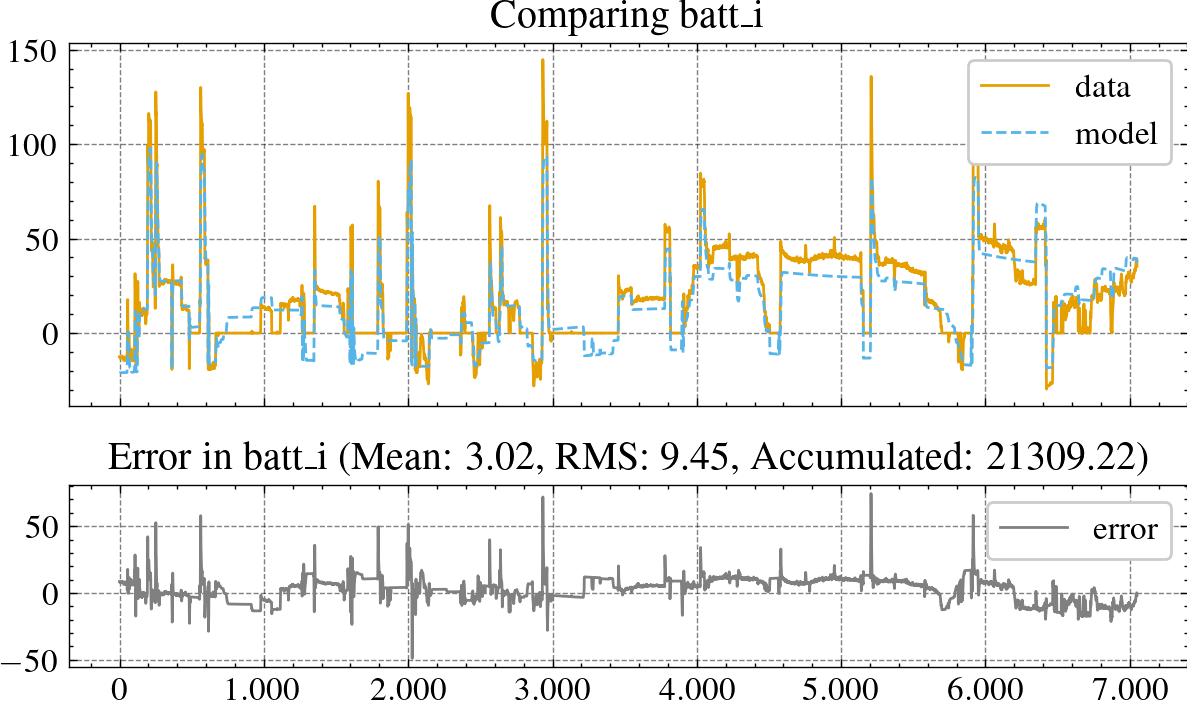

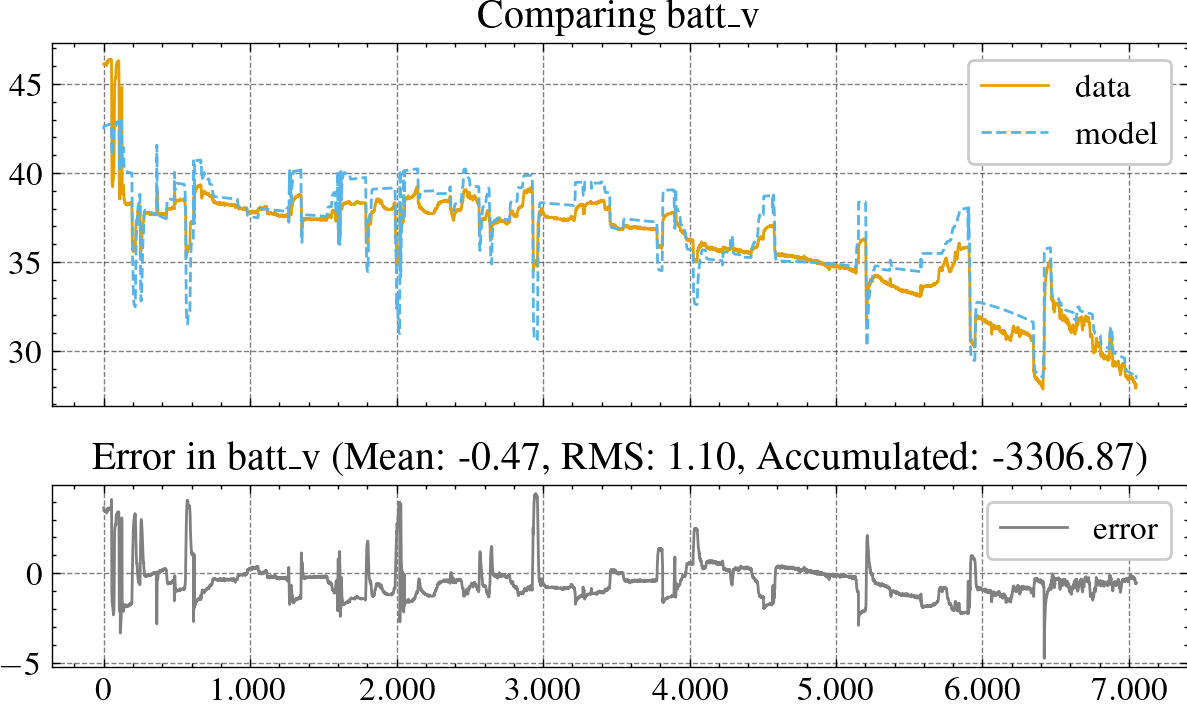

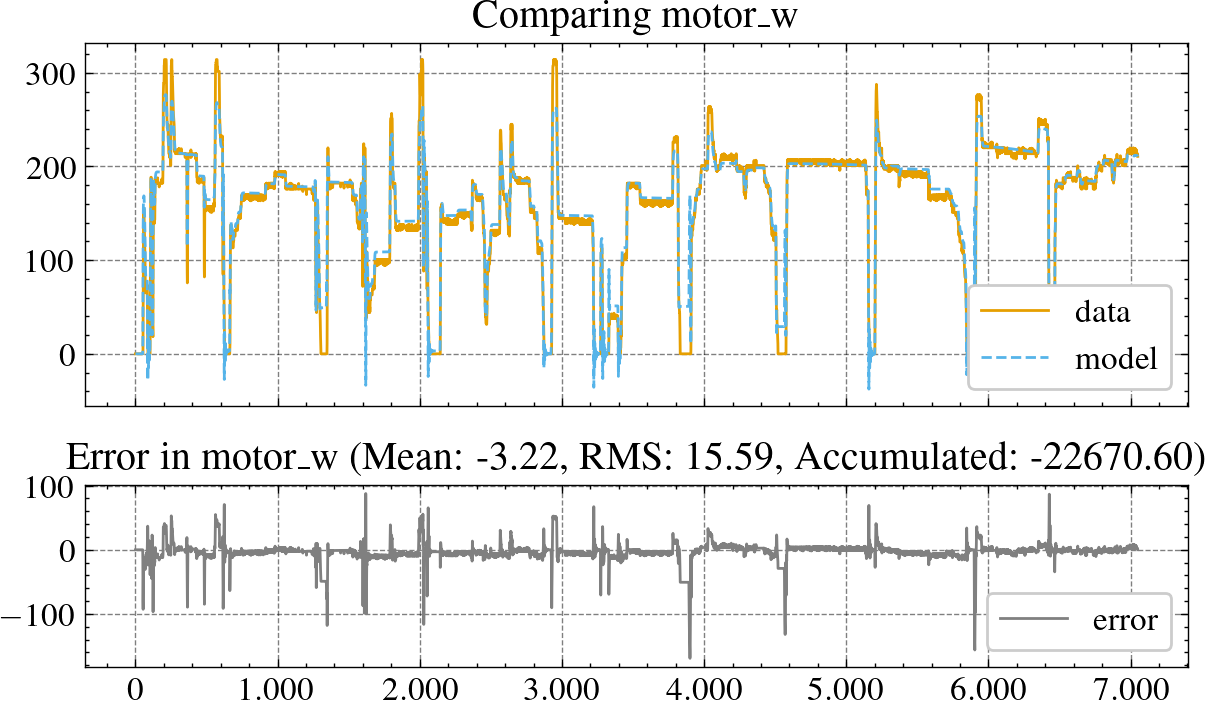

In [10]:
plot_compare(df, ydata, 'batt_i')
plot_compare(df, ydata, 'batt_v')
plot_compare(df, ydata, 'motor_w')

In [11]:
# to avoid warning messages
import warnings

warnings.filterwarnings("ignore")

## Create a Surrogate model

Mean Squared Error: 164.30528932733833


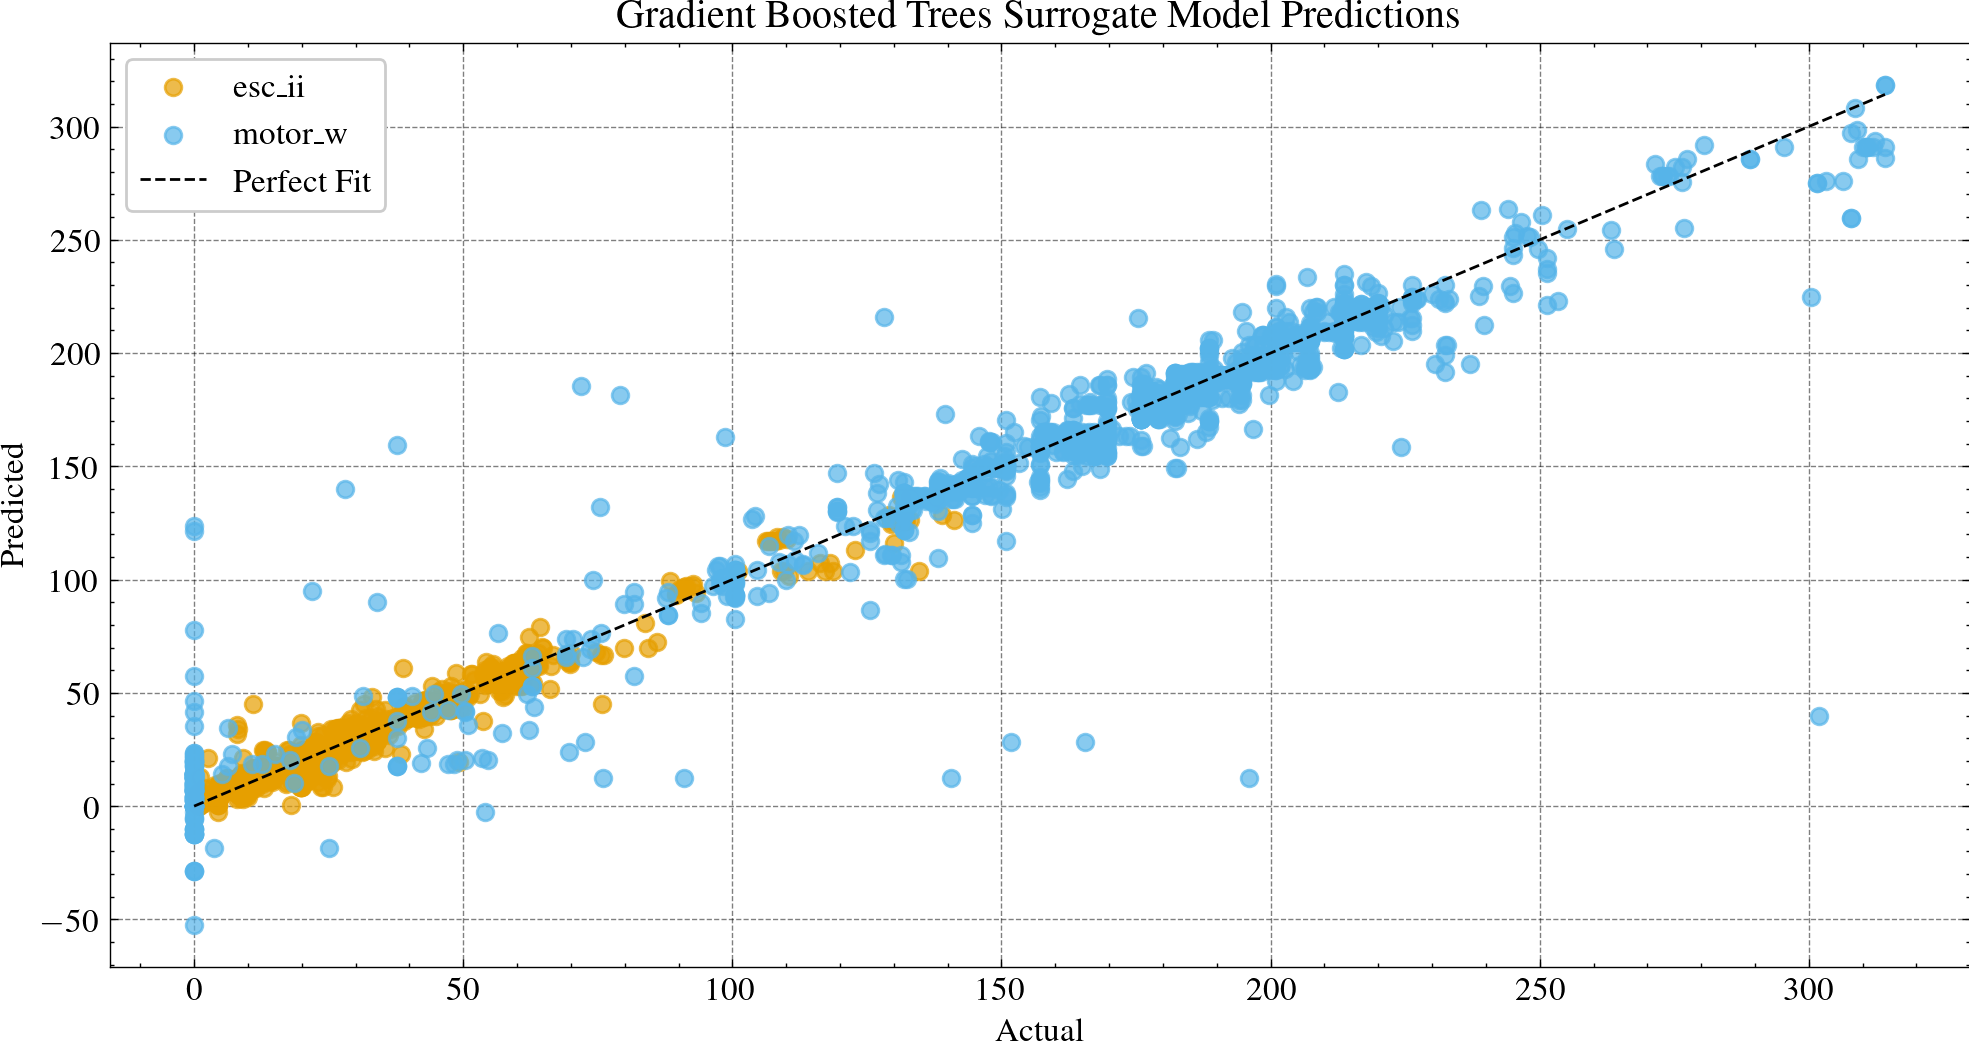

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb

# Assuming df_train is already defined with the necessary columns
data_cols = ['esc_i_in', 'motor_w']
df_train = dfa.copy(deep=True)[['solar_poa', 'esc_d'] + data_cols]

# Split the data into input (X) and output (y)
X = df_train[['solar_poa', 'esc_d']].values  # Input features
y = df_train[data_cols].values  # Target variables

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train separate models for each output variable
models = {}
predictions = []
for i, target in enumerate(data_cols):
    # Prepare training data for this target
    y_target_train = y_train[:, i]
    y_target_test = y_test[:, i]

    # Define and train the model
    model = xgb.XGBRegressor(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    model.fit(X_train, y_target_train)

    # Store the model and predict
    models[target] = model
    y_pred = model.predict(X_test)
    predictions.append(y_pred)

# Combine predictions for all target variables
y_pred_combined = np.column_stack(predictions)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred_combined)
print(f"Mean Squared Error: {mse}")

# Visualize predictions vs actual (optional)
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for i, target in enumerate(data_cols):
    plt.scatter(y_test[:, i], y_pred_combined[:, i], label=target, alpha=0.7)
plt.plot([min(y_test.ravel()), max(y_test.ravel())],
         [min(y_test.ravel()), max(y_test.ravel())],
         'k--', label='Perfect Fit')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.title('Gradient Boosted Trees Surrogate Model Predictions')
plt.show()


In [23]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [4, 6, 8],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

grid_search = GridSearchCV(
    xgb.XGBRegressor(random_state=42),
    param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1
)
grid_search.fit(X_train, y_train[:, 0])  # Run on first target variable
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300, 'subsample': 0.6}


In [26]:
import xgboost as xgb

# Train the model with the best parameters
model = xgb.XGBRegressor(
    colsample_bytree=1.0,
    learning_rate=0.1,
    max_depth=6,
    n_estimators=300,
    subsample=0.6,
    random_state=42
)

# Fit the model to your training data
model.fit(X_train, y_train)  # Adjust target variable selection if needed

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")


Mean Squared Error: 87.20921641444376


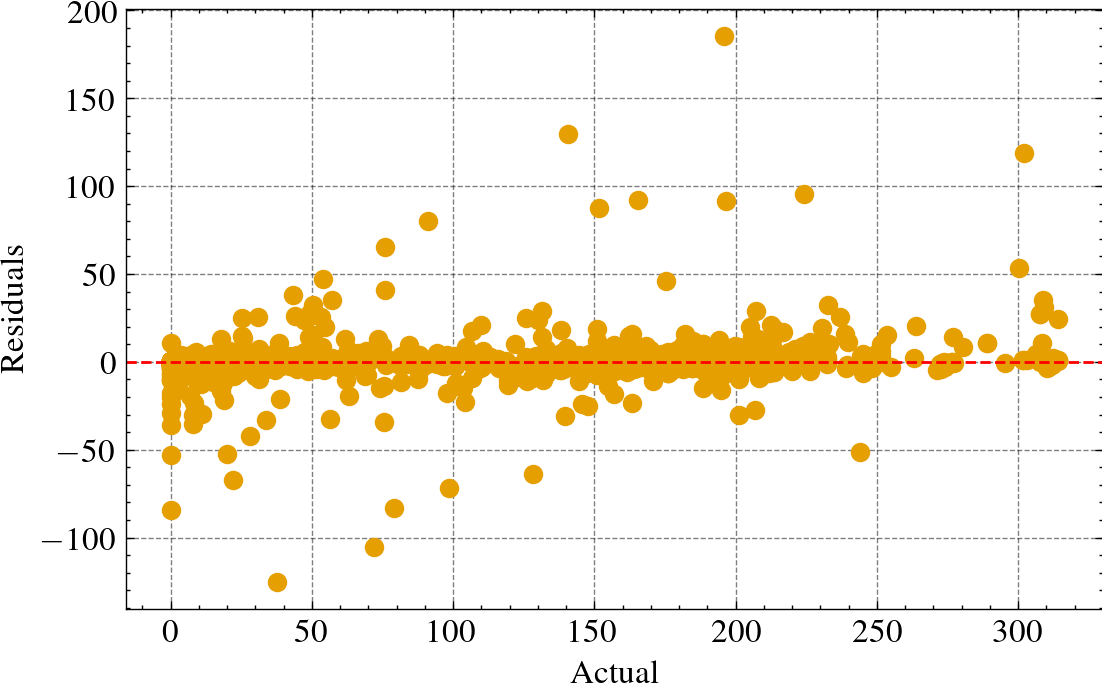

In [27]:
residuals = y_test - y_pred
plt.scatter(y_test, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Actual")
plt.ylabel("Residuals")
plt.show()

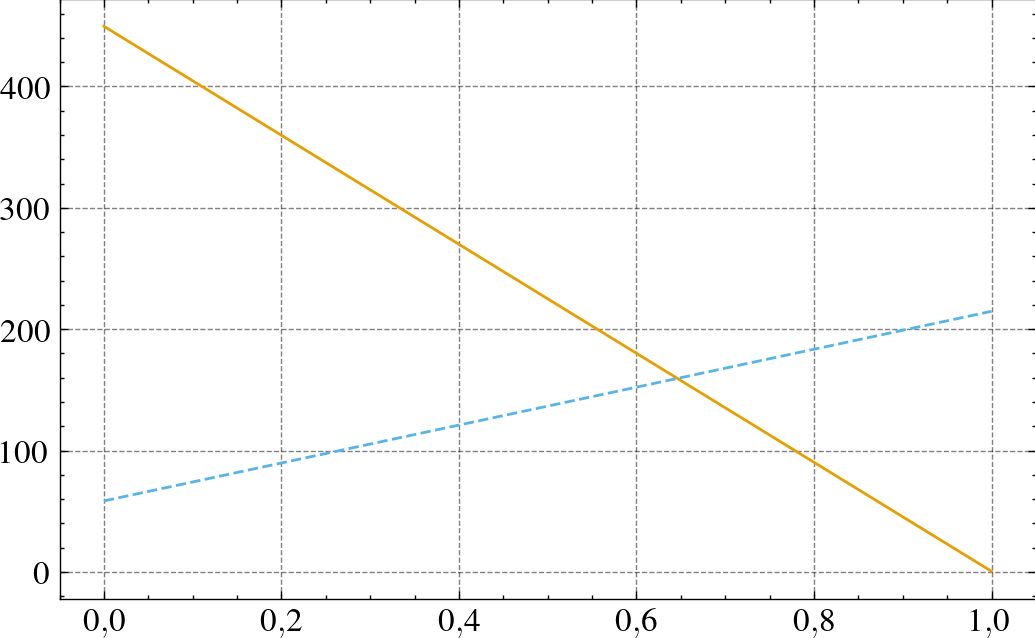

In [36]:
plt.plot(X_train[0])
plt.plot(y_pred[0])

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Neural Network Model
nn_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(len(data_cols))  # One output per target variable
])
nn_model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

# Train the model
history = nn_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# Predict and evaluate
y_pred_nn = nn_model.predict(X_test)
mse_nn = mean_squared_error(y_test, y_pred_nn)
print(f"Neural Network MSE: {mse_nn}")


2024-12-01 21:55:42.875009: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-01 21:55:42.875124: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-01 21:55:42.908635: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-01 21:55:42.978338: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-01 21:55:43.753282: W tensorflow/compiler/tf2

Epoch 1/50


2024-12-01 21:55:44.373109: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-12-01 21:55:44.373134: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: archmkrd
2024-12-01 21:55:44.373140: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: archmkrd
2024-12-01 21:55:44.373216: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 565.57.1
2024-12-01 21:55:44.373231: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 565.57.1
2024-12-01 21:55:44.373236: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:241] kernel version seems to match DSO: 565.57.1


141/141 [==============================] - 1s 1ms/step - loss: 3896.2957 - val_loss: 3118.9045
Epoch 2/50
141/141 [==============================] - 0s 827us/step - loss: 3513.7729 - val_loss: 3643.9922
Epoch 3/50
141/141 [==============================] - 0s 773us/step - loss: 3198.8540 - val_loss: 2618.9744
Epoch 4/50
141/141 [==============================] - 0s 767us/step - loss: 2974.7405 - val_loss: 2025.8114
Epoch 5/50
141/141 [==============================] - 0s 774us/step - loss: 2101.2490 - val_loss: 887.8466
Epoch 6/50
141/141 [==============================] - 0s 809us/step - loss: 1623.6940 - val_loss: 862.6157
Epoch 7/50
141/141 [==============================] - 0s 792us/step - loss: 1112.1454 - val_loss: 512.8544
Epoch 8/50
141/141 [==============================] - 0s 785us/step - loss: 1024.7469 - val_loss: 564.4192
Epoch 9/50
141/141 [==============================] - 0s 759us/step - loss: 976.8251 - val_loss: 521.9746
Epoch 10/50
141/141 [==========================

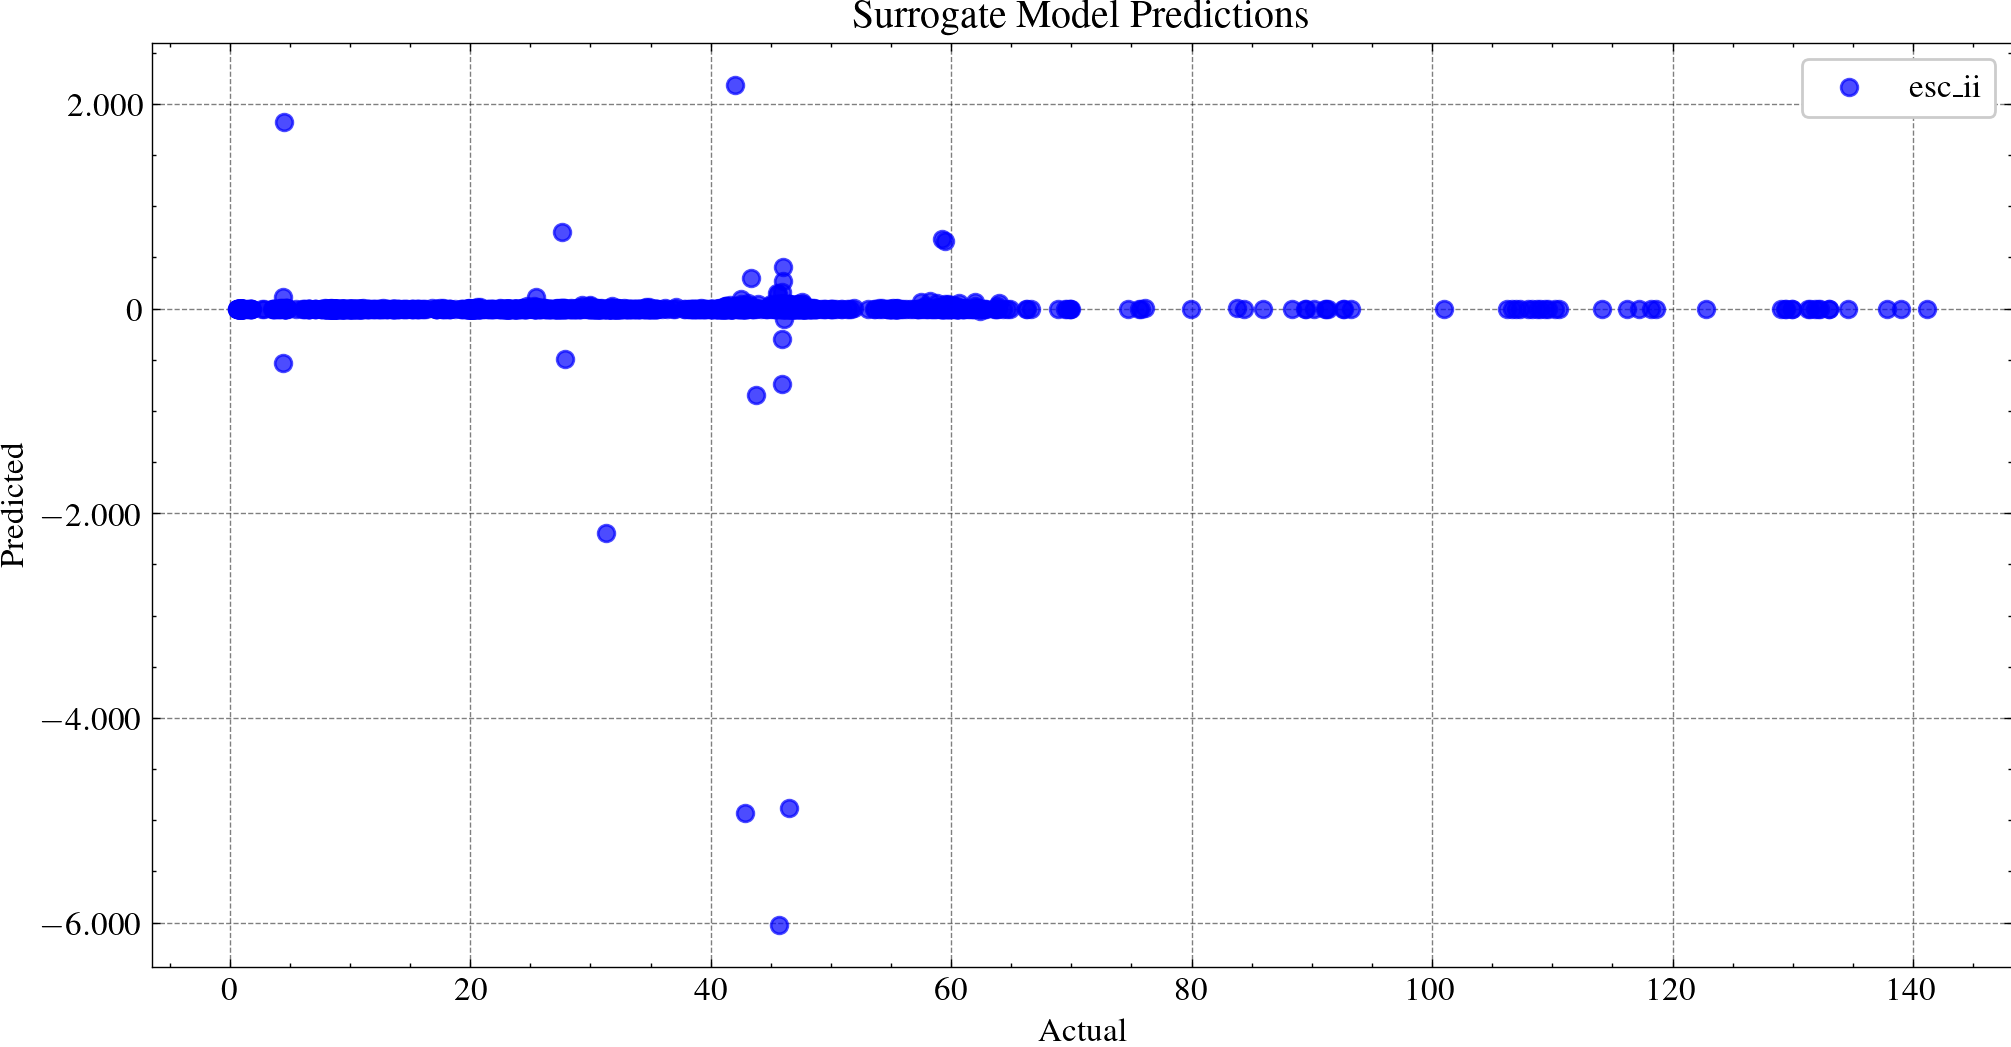

In [ ]:
# Visualize predictions vs actual (optional)
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.scatter(y_test[:, 0], y_pred[:, 0], label='esc_i_in', alpha=0.7, color='blue')
# plt.scatter(y_test[:, 1], y_pred[:, 1], label='motor_w', alpha=0.7, color='orange')
# plt.plot([min(y_test.ravel()), max(y_test.ravel())],
#          [min(y_test.ravel()), max(y_test.ravel())],
#          'k--', label='Perfect Fit')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.title('Surrogate Model Predictions')
plt.show()


## Testing optimization strategy with synthetic data

In [ ]:
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from pymoo.core.problem import ElementwiseProblem
from pymoo.optimize import minimize
from pymoo.algorithms.soo.nonconvex.nelder import NelderMead
from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.algorithms.soo.nonconvex.isres import ISRES
from pymoo.algorithms.soo.nonconvex.es import ES
from pymoo.algorithms.soo.nonconvex.de import DE
from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
from pymoo.algorithms.soo.nonconvex.pattern import PatternSearch
from pymoo.operators.sampling.lhs import LHS
from pymoo.termination.default import DefaultSingleObjectiveTermination
from pymoo.parallelization.starmap import StarmapParallelization
from multiprocessing.pool import ThreadPool
from multiprocessing import Pool
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import copy


class MyOptimizationProblem(ElementwiseProblem):
    def __init__(self, model_function, training_data, training_data_columns, model_params, opt_params_bounds, data_scaler=RobustScaler, **kwargs):
        assert all('min' in pb and 'max' in pb for pb in opt_params_bounds.values()), "All opt_params_bounds must have 'min' and 'max' keys"

        self.model_function = model_function
        self.model_params = model_params
        self.data_scaler = data_scaler
        self.training_data_columns = training_data_columns
        self.opt_param_names = list(opt_params_bounds.keys())

        # Model Time array
        T = (training_data.index[1] - training_data.index[0]).to_numpy().astype(np.float64) * 1e-9
        lenT = len(training_data.index)
        self.T = np.linspace(0, lenT * T, lenT, endpoint=False)

        # Model Input data
        self.U = training_data[['solar_poa', 'esc_d']].copy(deep=True).to_numpy().T

        # Model Initial state
        self.X0 = np.zeros(solar_boat.nstates)
        self.X0[solar_boat.state_index['batt_SOC']] = 1

        # Store scale ground-truth data
        self.training_data = training_data[self.training_data_columns].to_numpy()
        self.data_scaler = data_scaler().fit(self.training_data)
        self.training_data = self.scale_data(self.training_data)

        super().__init__(
            n_var=len(self.opt_param_names),  # Number of parameters to optimize
            n_obj=1,  # Single objective
            n_constr=0,  # No constraints
            xl=np.array([p['min'] for p in opt_params_bounds.values()]),  # Lower bounds for parameters
            xu=np.array([p['max'] for p in opt_params_bounds.values()]),  # Upper bounds for parameters
            **kwargs,
        )

    def _evaluate(self, x, out, *args, **kwargs):
        out["F"] = self.objective_function(x, *args, **kwargs)

    def objective_function(self, x, *args, **kwargs):
        input_params = {k: x[i] for (i, k) in enumerate(self.opt_param_names)}
        model_params = self.model_params | self.convert_to_model_params(input_params)

        # Run the simulation
        try:
            model_predictions = self.model_function(T=self.T, U=self.U, X0=self.X0, **model_params)[self.training_data_columns].to_numpy()
        except Exception as e:
            print(f"Error in model_function: {e}")
            return 1e9  # Penalize parameters that break the model

        # Scale model predictions
        scaled_model_predictions = self.scale_data(model_predictions)

        return mean_squared_error(self.training_data, scaled_model_predictions)

    def convert_to_model_params(self, input_params):
        """ Helper to convert between our input_params and the model input_params """
        if 'batt_ocv_coeff_0' not in input_params:
            return input_params

        n_coeffs = sum(1 for k in input_params if k.startswith('batt_ocv_coeff_'))
        return input_params | {'batt_k_V_OC_coeffs': [input_params[f'batt_ocv_coeff_{i}'] for i in range(n_coeffs)]}

    def scale_data(self, data):
        """ Helper to scale data """
        return self.data_scaler.transform(data)

    def rescale_data(self, data):
        """ Helper rescale data """
        return self.data_scaler.inverse_transform(data)


def model_function(T, U, X0, **params):
    return ct.input_output_response(
        SolarBoat.build(params=params),
        T=T,
        U=U,
        X0=X0,
        solve_ivp_method='Radau',
    ).to_pandas()


def plot_optimization_params(result):
    # Extract data from the result's history
    parameters = []
    generations = []
    optimal_parameters = []

    for gen_idx, entry in enumerate(result.history):
        X = entry.pop.get("X")  # Parameter values
        F = entry.pop.get("F")  # Objective values

        generations.extend([gen_idx] * len(X))  # Repeat the generation index for each individual
        parameters.extend(X)

        # Find the best parameter set in the current generation
        best_idx = np.argmin(F)
        optimal_parameters.append(X[best_idx])

    parameters = np.array(parameters)
    generations = np.array(generations)
    optimal_parameters = np.array(optimal_parameters)

    # Number of parameters
    parameters_names = list(params_bounds.keys())
    n_params = parameters.shape[1]

    # Create subplots
    fig, axes = plt.subplots(1, n_params, figsize=(2 * n_params, 6), sharey=True)  # Adjust subplot width
    if n_params == 1:  # Ensure axes are iterable even for a single parameter
        axes = [axes]

    for i, ax in enumerate(axes):
        # Scatter plot for parameter i
        ax.scatter(parameters[:, i], generations, alpha=0.5, s=5)

        # Plot optimal parameter values as a black line
        ax.plot(optimal_parameters[:, i], np.arange(len(optimal_parameters)), color='k', lw=1.5, label="Optimal")

        ax.set_title(parameters_names[i])
        ax.set_xlabel("Value")
        ax.set_ylabel("Generation" if i == 0 else "")  # Label only the first subplot's y-axis
        ax.grid(True)

    # Adjust subplot spacing
    plt.gca().invert_yaxis()
    plt.subplots_adjust(wspace=0.3)  # Add spacing between subplots
    plt.tight_layout()
    plt.show()

def plot_optimization_error(result):
    n_evals = []             # corresponding number of function evaluations
    hist_F = []              # the objective space values in each generation

    for algo in result.history:
        # store the number of function evaluations
        n_evals.append(algo.evaluator.n_eval)

        # retrieve the optimum from the algorithm
        opt = algo.opt

        # filter out only the feasible and append and objective space values
        feas = np.where(opt.get("feasible"))[0]
        hist_F.append(opt.get("F")[feas])

    n_evals = np.array(n_evals).ravel()
    hist_F = np.array(hist_F).ravel()

    plt.figure()
    plt.plot(n_evals, hist_F)
    plt.xlabel('Evaluations')
    plt.ylabel('MSE')
    plt.show()

In [ ]:
## PROPULSION OPTIMIZATION

# Select the optimization data
data_cols = ['esc_i_in', 'motor_w']

# Put simulation data into df
df_train = dfa.copy(deep=True)
df_train = df_train[['solar_poa', 'esc_d']]
df_train[data_cols] = ydata[data_cols].to_numpy()

# Initialize Parameters
params_bounds = {
    # 'pv_eta': dict(min=solar_boat_params['pv_eta']/10, max=solar_boat_params['pv_eta']*10),
    # 'mppt_eta': dict(min=solar_boat_params['mppt_eta']/10, max=solar_boat_params['mppt_eta']*10),
    # 'batt_R_0': dict(min=solar_boat_params['batt_R_0']/10, max=solar_boat_params['batt_R_0']*10),
    # 'batt_R_1': dict(min=solar_boat_params['batt_R_1']/10, max=solar_boat_params['batt_R_1']*10),
    # 'batt_C_1': dict(min=solar_boat_params['batt_C_1']/10, max=solar_boat_params['batt_C_1']*10),
    'motor_R_A': dict(min=solar_boat_params['motor_R_A']/10, max=solar_boat_params['motor_R_A']*10),
    'motor_L_A': dict(min=solar_boat_params['motor_L_A']/10, max=solar_boat_params['motor_L_A']*10),
    'motor_B': dict(min=solar_boat_params['motor_B']/10, max=solar_boat_params['motor_B']*10),
    'motor_I_r': dict(min=solar_boat_params['motor_I_r']/10, max=solar_boat_params['motor_I_r']*10),
    'motor_I_r_load': dict(min=solar_boat_params['motor_I_r_load']/10, max=solar_boat_params['motor_I_r_load']*10),
    # 'motor_K_Q': dict(min=solar_boat_params['motor_K_Q']/10, max=solar_boat_params['motor_K_Q']*10),
    'prop_K_Q': dict(min=solar_boat_params['prop_K_Q']/10, max=solar_boat_params['prop_K_Q']*10),
    # 'prop_D': dict(min=solar_boat_params['prop_D']/10, max=solar_boat_params['prop_D']*10),
    # 'trans_k': dict(min=solar_boat_params['trans_k']/10, max=solar_boat_params['trans_k']*10),
}

# Initialize the thread pool and create the runner
n_processes = 32
pool = Pool(processes=n_processes)
runner = StarmapParallelization(pool.starmap)

# Initialize the problem
problem = MyOptimizationProblem(
    model_function=model_function,
    training_data=df_train,
    training_data_columns=data_cols,
    model_params=solar_boat_params,
    opt_params_bounds=params_bounds,
    data_scaler=RobustScaler,
    elementwise_runner=runner,
)

# algorithm = ISRES(n_offsprings=1000, rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
algorithm = DE(
    pop_size=10*len(params_bounds),
    sampling=LHS(),
    variant="DE/rand/1/bin",
    F=0.2,
    CR=0.9,
)

# Specify termination criteria (optional)
termination = DefaultSingleObjectiveTermination(
    xtol=1e-8,
    cvtol=1e-6,
    ftol=1e-6,
    period=20,
    n_max_gen=1000,
    n_max_evals=100000
)

# Run the optimization
result = minimize(
    problem,
    algorithm,
    termination=termination,
    seed=42,
    verbose=True,
    save_history=True,
)
print('Threads:', result.exec_time)
pool.close()
pool.join()

In [ ]:
# Print the results
best_params = {k: result.X[i] for (i, k) in enumerate(params_bounds.keys())}
print("Original parameters were:")
display({k: solar_boat_params[k] for k in params_bounds.keys()})
print("Best parameters found:")
display(best_params)
print("Objective value at solution:", result.F)

plot_optimization_params(result)
plot_optimization_error(result)

best_fit_data = model_function(T, U, X0, **(solar_boat_params | best_params))

for col in data_cols:
    plot_compare(df, best_fit_data, col)

In [ ]:
## BATTERY OPTIMIZATION

# Select the optimization data
data_cols = ['batt_v', 'batt_i']

# Put simulation data into df
df_train = dfa.copy(deep=True)
df_train = df_train[['solar_poa', 'esc_d']]
df_train[data_cols] = ydata[data_cols].to_numpy()

# Initialize Parameters
params_bounds = {
    # 'pv_eta': dict(min=solar_boat_params['pv_eta']/10, max=solar_boat_params['pv_eta']*10),
    # 'mppt_eta': dict(min=solar_boat_params['mppt_eta']/10, max=solar_boat_params['mppt_eta']*10),
    'batt_R_0': dict(min=solar_boat_params['batt_R_0']/10, max=solar_boat_params['batt_R_0']*10),
    'batt_R_1': dict(min=solar_boat_params['batt_R_1']/10, max=solar_boat_params['batt_R_1']*10),
    'batt_C_1': dict(min=solar_boat_params['batt_C_1']/10, max=solar_boat_params['batt_C_1']*10),
}
for i in range(0, len(solar_boat_params['batt_k_V_OC_coeffs'])):
    params_bounds[f'batt_ocv_coeff_{i}'] = dict(min=-1e9, max=1e9)

# Initialize the thread pool and create the runner
n_processes = 32
pool = Pool(processes=n_processes)
runner = StarmapParallelization(pool.starmap)

# Initialize the problem
problem = MyOptimizationProblem(
    model_function=model_function,
    training_data=df_train,
    training_data_columns=data_cols,
    model_params=solar_boat_params,
    opt_params_bounds=params_bounds,
    data_scaler=RobustScaler,
    elementwise_runner=runner,
)

# algorithm = ISRES(n_offsprings=1000, rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
algorithm = DE(
    pop_size=10*len(params_bounds),
    sampling=LHS(),
    variant="DE/rand/1/bin",
    F=0.2,
    CR=0.9,
)

# Specify termination criteria (optional)
termination = DefaultSingleObjectiveTermination(
    xtol=1e-8,
    cvtol=1e-6,
    ftol=1e-6,
    period=20,
    n_max_gen=1000,
    n_max_evals=100000
)

# Run the optimization
result = minimize(
    problem,
    algorithm,
    termination=termination,
    seed=42,
    verbose=True,
    save_history=True,
)
print('Threads:', result.exec_time)
pool.close()
pool.join()

# Print the results
best_params = {k: result.X[i] for (i, k) in enumerate(params_bounds.keys())}
print("Original parameters were:")
display({k: solar_boat_params[k] for k in params_bounds.keys()})
print("Best parameters found:")
display(best_params)
print("Objective value at solution:", result.F)

plot_optimization_params(result)
plot_optimization_error(result)

best_fit_data = model_function(T, U, X0, **(solar_boat_params | best_params))

for col in data_cols:
    plot_compare(df, best_fit_data, col)